# Simulating optical auto correlation of a pulsed laser (with chirp)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants
from scipy import integrate
from scipy import fftpack

from IPython.core.debugger import set_trace
from datetime import datetime

Electric field of the laser $E_0(t)$ is relative to the form:

$$ E_0(t) \sim f_0(t) = \frac{A}{\sqrt{2 \cdot \pi \cdot \tau_0^2}} \exp\left(-\frac{t^2}{2 \cdot \tau_0^2}\right)\exp(-i \omega t)$$

with the orginal pulse area $A$, the pulse duration $\tau_0$ and the central frequency $w$.

Applying a Gaussian chirp filter with the chirp coefficient $\alpha$ transforms $f_0(t)$ into

$$E(t) \sim f(t) = \frac{A}{\sqrt{2 \cdot \pi \cdot \tau_0 \cdot \tau}} \exp\left(-\frac{t^2}{2 \cdot \tau^2}\right)\exp\left(-i \omega t - i \frac{at^2}{2}\right)$$

where $\tau = \sqrt{\alpha^2 / \tau_0^2 + \tau_0^2}$ characterizes the chirped pulse length and $a = \alpha/(\alpha^2+\tau_0^4)$ is the frequency chirp rate.

(see Glässl, M. et al. Biexciton state preparation in a quantum dot via adiabatic rapid passage: Comparison between two control protocols and impact of phonon-induced dephasing. Phys. Rev. B - Condens. Matter Mater. Phys. 87, 1–8 (2013).).

In [2]:
def gen_tau(alpha, tau_0):
    return np.sqrt(alpha**2 / tau_0**2 + tau_0**2)

def gen_a(alpha, tau_0):
    return alpha / (alpha**2 + tau_0**4)

def E_gauss(t, A, tau_0, omega, alpha):
    return A / np.sqrt(2 * np.pi * tau_0 * gen_tau(alpha, tau_0)) * np.exp(- t**2 / (2 * gen_tau(alpha, tau_0)**2)) *  np.exp(-1j * omega * t - 1j * gen_a(alpha, tau_0) * t**2 / 2)



MaiTai Laser | values
-----------|--------------
repitition rate| 80 MHz
center wavelength (tunable) $\lambda_0$| 700 nm to 1000 nm
power | 3.2 Watt
pulse duration $\tau_0$ | 100 fs - 20 ps

We start with the pulse duration $\tau_0$ in (ps) and choose for the central wavelength $\lambda$ = 785e3 (pm).

We also define the original pulse area $A$.

In [3]:
A_laser = 1
tau_0_laser = 5
lambda_laser = 785e3

omega_laser = 2 * np.pi * constants.c / lambda_laser

We calculate E for different $\alpha$ in (ps)$^2$.

In [4]:
alpha_values = np.array((0, 1e-2, 10))

Set t_limit to 0.8 (ps)

In [5]:
t_limit = 3 * tau_0_laser

In [6]:
t_values_1 = np.linspace(-t_limit, t_limit * 3, 3000)

E_gauss_values_1 = np.empty((t_values_1.size, alpha_values.size), dtype=complex)
for i in range(alpha_values.size):
    E_gauss_values_1[:,i] = E_gauss(t_values_1, A_laser, tau_0_laser,
                                    omega_laser, alpha_values[i])

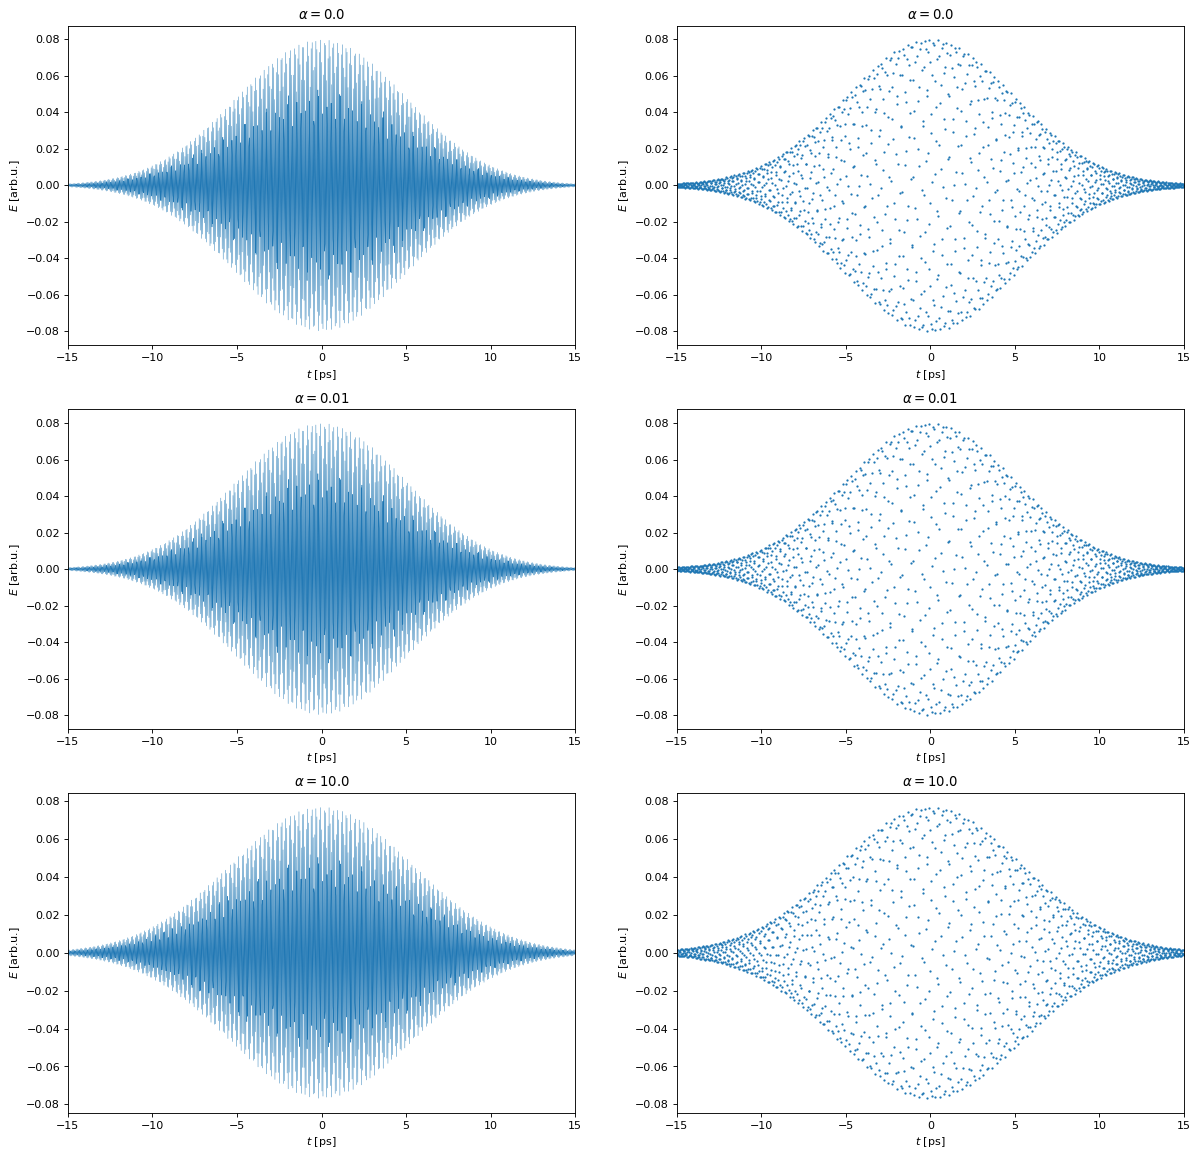

In [7]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(18, 18), dpi=80)
for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel(r"$t$ [ps]")
    plt.ylabel(r"$E$ [arb.u.]")
    plt.xlim(-t_limit, t_limit)
    plt.plot(t_values_1, np.real(E_gauss_values_1[:,i]), linewidth=0.4)
    
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel(r"$t$ [ps]")
    plt.ylabel(r"$E$ [arb.u.]")
    plt.xlim(-t_limit , t_limit)
    plt.plot(t_values_1, np.real(E_gauss_values_1[:,i]), ".", markersize=2)

plt.show()

# Interferometric autocorrelation

![Setup for an interferometric autocorrelator](https://upload.wikimedia.org/wikipedia/en/d/dd/Optical-interferometric-autocorrelation-setup.png)

Setup for an interferometric autocorrelator, similar to the field autocorrelator above, with the following optics added:
- **L**: converging lens,
- **SHG**: second-harmonic generation crystal,
- **F**: spectral filter to block the fundamental wavelength.

(see https://en.wikipedia.org/wiki/Optical_autocorrelation)

The intensity recorded by the detecter is:

$$ I_M(\tau) = \int_{-\infty}^{+\infty}|(E(t)+E(t-\tau))^2|^2dt $$

In [8]:
def I_M_gauss(tau_values, A, tau_0, omega, alpha):
    I_M_values = np.array(())
    for tau in tau_values:
        func = lambda t: np.abs((E_gauss(t, A, tau_0, omega, alpha)
                                 + E_gauss(t - tau, A, tau_0, omega, alpha))**2)**2
        # "[0]" because quad returns array, with "[0]" as the result and "[1]" as the error
        I_M_values = np.append(I_M_values,
                               integrate.quad(func, - np.inf, np.inf)[0])        
    return I_M_values

Number of $\tau$-values to calculate:

In [9]:
tau_limit = tau_0_laser * 4

Calculate the number of values so we can fft to at least $2.5 \cdot \omega$ 

$$2.5 \cdot \frac{\omega_{laser}}{2\pi} < f_{nyq} = \frac{f_{sampling}}{2} = \frac{\frac{\textit{number_tau_values}}{\textit{tau_limit} \cdot 2}}{2} $$

$$\Rightarrow \textit{number_tau_values} = \frac{5}{\pi} \cdot \textit{tau_limit} \cdot \omega_{laser} $$

In [10]:
number_tau_values = int(5 / np.pi * tau_limit * omega_laser)

In [11]:
tau_values_1 = np.linspace(-tau_limit, tau_limit, number_tau_values)

I_M_gauss_values_1 = np.empty((tau_values_1.size, alpha_values.size))
for i in range(alpha_values.size):
    I_M_gauss_values_1[:,i] = I_M_gauss(tau_values_1, A_laser, tau_0_laser,
                                        omega_laser, alpha_values[i])

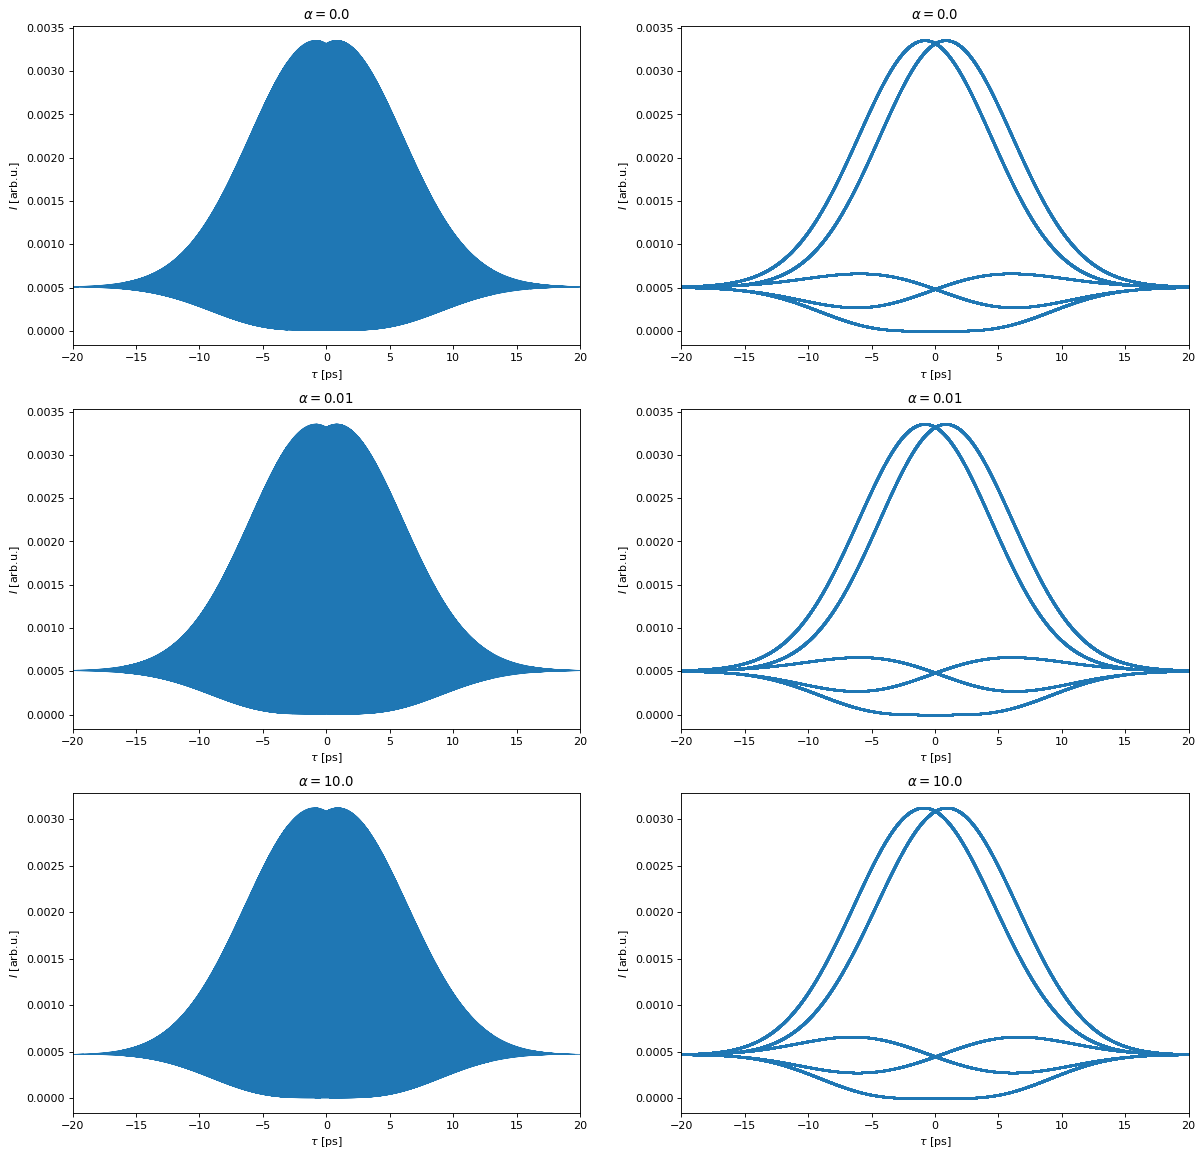

In [12]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(18, 18), dpi=80)

for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$I$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_gauss_values_1[:,i], linewidth=0.2)
   
    
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$I$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_gauss_values_1[:,i], ".", markersize=2)    

plt.show()

In [13]:
path = r"../../Data/Autocorrelator/Simulation/"

In [14]:
np.savetxt(path + "Autocorrelation_Simulation_Gauss_" +
           str(datetime.now()).replace(":", "_") + ".txt",
           np.append(tau_values_1[:, np.newaxis], I_M_gauss_values_1, axis=1),
           header = "tau_values | I(alpha = " + str(alpha_values) + ")")